In [2]:
# System libraries
import sys, os, gc
import datetime

# Math libraries
import math, random
import pandas as pd, numpy as np
import scipy
from scipy import stats
from datetime import timedelta
from datetime import datetime
import itertools

# Data storage libraries
import pickle, sqlite3, simpledbf, boto3

# Custom financial data libraries
import findata_utils as fd
import ml_utils

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams

import warnings
#if not sys.warnoptions:
#    warnings.simplefilter("ignore")

from importlib import reload
fd = reload(fd)

import sklearn as sk
import tensorflow as tf
import xgboost as xgb
import keras

from imblearn.over_sampling import RandomOverSampler

from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib 

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

from yellowbrick.regressor import ResidualsPlot, PredictionError

# Connect to databases
db = 'C:\\Datasets\\thesis.db'
overleaf = ['C:','Users','bryce','OneDrive','Documents','Overleaf','5babbfe264c952737a9a5117','esc499']
conn = sqlite3.connect(db)
c = conn.cursor()

hdf_path = 'C:\\Datasets\\thesis.h5'
hdf = pd.HDFStore(hdf_path)

## Obtain expected returns; compute abnormal returns

In [427]:
df = pd.read_sql('''
    SELECT *--ticker, date, rebal_date, action, [index], r_daily,
        --er_daily, ar_daily
    FROM daily_abnormal_returns''', conn)

bounds = [-1,10]
bounds_corr = [-5,5]

for corr in ['riskfree_return','market_excess_return','sector_excess_return','industry_excess_return',
             'riskfree_return_corr','market_excess_return_corr','sector_excess_return_corr','industry_excess_return_corr']:
    if '_corr' in corr:
        df[corr] = df[corr].clip(upper=max(bounds_corr)).clip(lower=min(bounds_corr))
    else:
        df[corr] = df[corr].clip(upper=max(bounds)).clip(lower=min(bounds))

df['riskfree_return_corr'] = df['riskfree_return_corr'].clip(lower=-1).clip(upper=1)
df['er_daily'] = df['riskfree_return']*df['riskfree_return_corr'] + df['market_excess_return']*df['market_excess_return_corr'] + df['sector_excess_return']*df['sector_excess_return_corr'] + df['industry_excess_return']*df['industry_excess_return_corr']
df['ar_daily'] = df['r_daily']-df['er_daily']

display(df.iloc[:5,:])

# This is now done in the sector_coherence.py script!

,ticker,date,rebal_date,action,index,r_daily,riskfree_return,market_excess_return,sector_excess_return
0,SMU.UN,2013-11-11,2019-03-18 00:00:00,Add,S&P/TSX Composite Index,0.014363,0.0,0.0012,0.044602
1,SMU.UN,2013-11-12,2019-03-18 00:00:00,Add,S&P/TSX Composite Index,-0.017890,0.0,-0.0022,0.066005
2,SMU.UN,2013-11-13,2019-03-18 00:00:00,Add,S&P/TSX Composite Index,0.003621,0.0,0.0088,-0.006116
3,SMU.UN,2013-11-14,2019-03-18 00:00:00,Add,S&P/TSX Composite Index,-0.026320,0.0,0.0043,0.010275
4,SMU.UN,2013-11-15,2019-03-18 00:00:00,Add,S&P/TSX Composite Index,0.008816,0.0,0.0044,0.032696


### Compute cumulative abnormal returns

In [428]:
# Compute number of days until the rebalance day
if 'd' not in df.columns:
    for field in ['rebal_date', 'date']:
        df[field] = df[field].apply(lambda date: datetime.strptime(date[:10], '%Y-%m-%d') if type(date)==str else date)
    df['d'] = (df['date']-df['rebal_date']).apply(lambda d: d.days)
    
# Deal with infinities
df = df.replace(-np.inf,min(bounds))
df = df.replace(np.inf,max(bounds))
for column in ['r_daily','er_daily','ar_daily']:
    df[column] = df[column].clip(lower=min(bounds))
    df[column] = df[column].clip(upper=max(bounds))

# Compute the abnormal returns, per security
abnormal_returns = df.pivot_table(index=['d'], columns=['ticker'], values=['r_daily','ar_daily','er_daily'])

# Compute cumulative returns, per security
cars = (abnormal_returns+1).cumprod()-1

# Now, index all culm returns to day 0
cars_indexed = (cars.subtract(cars.loc[cars.index==0].iloc[0,:],axis=1))
#cars_indexed.clip

# Fill NAs
cars_indexed.loc[cars_indexed.index==0] = cars_indexed.loc[cars_indexed.index==0].fillna(0)
cars_indexed.loc[cars_indexed.index>=0] = cars_indexed.loc[cars_indexed.index>=0].fillna(method='ffill')
cars_indexed.loc[cars_indexed.index<=0] = cars_indexed.loc[cars_indexed.index<=0].fillna(method='bfill')

display(cars_indexed.iloc[:5,:])

ar_daily                                                             
ticker      AAV  ABX         AC       ACB ACO.X      ACQ        AD  AEM AEZS
d                                                                           
-3360       0.0  0.0 -20.674735  0.998254   0.0  1.01318  1.006076  0.0  0.0
-3359       0.0  0.0 -20.674735  0.998254   0.0  1.01318  1.006076  0.0  0.0
-3358       0.0  0.0 -20.674735  0.998254   0.0  1.01318  1.006076  0.0  0.0
-3357       0.0  0.0 -20.674735  0.998254   0.0  1.01318  1.006076  0.0  0.0
-3356       0.0  0.0 -20.674735  0.998254   0.0  1.01318  1.006076  0.0  0.0

### Compute summary statistics for CARs

In [333]:
actions = df[['ticker','action','index']].drop_duplicates()
del_cars = cars_indexed.loc[:,cars_indexed.columns.get_level_values(1).isin(actions.loc[actions['action']=='Delete']['ticker'].values)]
add_cars = cars_indexed.loc[:,cars_indexed.columns.get_level_values(1).isin(actions.loc[actions['action']=='Add']['ticker'].values)]

In [468]:
avg_rw_end = -df['rebal_date'].apply(lambda day: day.day).mean()
avg_rw_start = avg_rw_end - 13

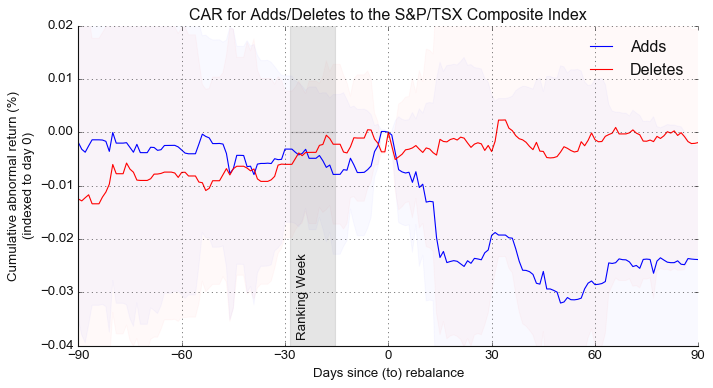

In [504]:
plt.style.use('classic')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

stds = 0.12

plt.plot(cars_indexed.index, add_cars['ar_daily'].mean(axis=1), color='blue')
ax.fill_between(cars_indexed.index,
                add_cars['ar_daily'].mean(axis=1)-add_cars['ar_daily'].std(axis=1)*stds,
                add_cars['ar_daily'].mean(axis=1)+add_cars['ar_daily'].std(axis=1)*stds,
                color='blue', alpha=0.025)

plt.plot(cars_indexed.index, del_cars['ar_daily'].mean(axis=1), color='red')
ax.fill_between(cars_indexed.index,
                del_cars['ar_daily'].mean(axis=1)-add_cars['ar_daily'].std(axis=1)*stds,
                del_cars['ar_daily'].mean(axis=1)+add_cars['ar_daily'].std(axis=1)*stds,
                color='red', alpha=0.025)

ax.fill_between([avg_rw_start,avg_rw_end], [1,1], color='grey', alpha=0.2)
ax.fill_between([avg_rw_start,avg_rw_end], [-1,-1], color='grey', alpha=0.2)

plt.legend(['Adds','Deletes'], frameon=False, loc='best')
plt.title('CAR for Adds/Deletes to the %s' % ('S&P/TSX Composite Index'))
plt.xlabel('Days since (to) rebalance')
plt.ylabel('Cumulative abnormal return (%)\n(indexed to day 0)')
xlim = [-90,90]
plt.xlim(xlim)
ylim = [-0.04,0.02]
plt.ylim(ylim)
plt.xticks(np.linspace(-90,90,7))

plt.text(avg_rw_start + 2, min(ylim) + 0.001, 'Ranking Week', rotation=90,
         horizontalalignment='left',verticalalignment='bottom', fontsize=12)

plt.show()

In [430]:
df['sector_return'] = df['riskfree_return']+df['market_excess_return']+df['sector_excess_return']
df['industry_return'] = df['sector_return']+df['industry_excess_return']

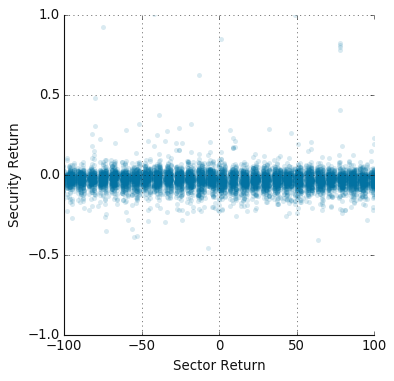

In [510]:
plt.style.use('classic')
fig = plt.figure(figsize=(5,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

coherence = df.loc[df['ticker'].isin(actions.loc[actions['action']=='Delete']['ticker'].values)][['d','sector_return','r_daily']]
ax.scatter(coherence['d'], coherence['r_daily']-coherence['sector_return'], linewidths=0, alpha=0.15)

plt.xlabel('Sector Return')
plt.ylabel('Security Return')
plt.xlim([-100,100])
plt.ylim([-1,1])
plt.show()